### Let's start with some imports

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
%config IPCompleter.greedy=True

### Fetching data

In [63]:
df_mitbih = pd.read_csv('data/mitbih_train.csv', header=None)
df2_mitbih = pd.read_csv('data/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih, df2_mitbih], axis=0)

df_ptbdb = pd.read_csv('data/ptbdb_normal.csv', header=None)
df2_ptbdb = pd.read_csv('data/ptbdb_abnormal.csv', header=None)
df_ptbdb = pd.concat([df_ptbdb, df2_ptbdb], axis=0)

print(df_mitbih.info())
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB
None


## Model

The model is based on this article : https://arxiv.org/abs/1805.00794

In [39]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [5]:
input_shape = (187, 1)

def make_model(final_layer_size=5):
    I = Input(input_shape)
    C = Conv1D(filters=32, kernel_size=5)(I)

    C11 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(C)
    C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
    A11 = Add()([C, C12])
    R11 = Activation(activation='relu')(A11)
    M11 = MaxPool1D(pool_size=5, strides=2)(R11)

    C21 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M11)
    C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
    A21 = Add()([M11, C22])
    R21 = Activation(activation='relu')(A21)
    M21 = MaxPool1D(pool_size=5, strides=2)(R21)

    C31 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M21)
    C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
    A31 = Add()([M21, C32])
    R31 = Activation(activation='relu')(A31)
    M31 = MaxPool1D(pool_size=5, strides=2)(R31)

    C41 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M31)
    C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
    A41 = Add()([M31, C42])
    R41 = Activation(activation='relu')(A41)
    M41 = MaxPool1D(pool_size=5, strides=2)(R41)

    C51 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M41)
    C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
    A51 = Add()([M41, C52])
    R51 = Activation(activation='relu')(A51)
    M51 = MaxPool1D(pool_size=5, strides=2)(R51)

    F1 = Flatten()(M51)
    D1 = Dense(32)(F1)
    R1 = Activation(activation='relu')(D1)
    D2 = Dense(32)(R1)
    D3 = Dense(final_layer_size)(D2)

    O = Activation(activation='softmax')(D3)

    return Model(inputs=I, outputs=O)

model = make_model(final_layer_size=5)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
_____________

"For training the networks, we used Adam optimization method with the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999, respectively. Learning rate is decayed exponentially with the decay factor of 0.75 every 10000 iterations."

In [6]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

### First, let's work on the ptbdb dataset

In [64]:
M = df_ptbdb.values
X = M[:,:-1]
y = M[:,-1]
print(X.shape)
print(y.shape)
print(y[:10])
print(y[-10:])

(14552, 187)
(14552,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


y is the concatenation of normal + abnormal, in that order. Hence, the classes are :

1 : abnormal

0 : normal

### First, let's work on the ptbdb dataset

In [40]:
M = df_ptbdb.values
X = M[:,:-1]
y = M[:,-1]
print(X.shape)
print(y.shape)

(14552, 187)
(14552,)


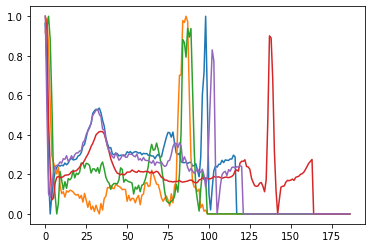

In [45]:
plt.plot(X[np.random.randint(0,X.shape[0],5)].transpose())

In [48]:
n_classes = len(np.unique(y))
model = make_model(n_classes)
M = df_ptbdb.values
X = M[:,:-1]
y = M[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [75]:
n_classes = len(np.unique(y))
model = make_model(n_classes)


In [76]:
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
mc = tf.keras.callbacks.ModelCheckpoint('weights/ptbdb{epoch:08d}.h5', save_weights_only=True, period=5)
history = model.fit(np.expand_dims(X_train, axis=2), 
                    y_train, 
                    validation_split=0.15,
                    epochs=30,
                    batch_size=256,
                    callbacks=[mc])

Train on 10513 samples, validate on 1856 samples
Epoch 1/30
10513/10513 [==============================] - 12s 1ms/sample - loss: 0.5302 - acc: 0.7350 - val_loss: 0.5482 - val_acc: 0.7452
Epoch 2/30
10513/10513 [==============================] - 9s 830us/sample - loss: 0.3497 - acc: 0.8463 - val_loss: 0.3244 - val_acc: 0.8567
Epoch 3/30
10513/10513 [==============================] - 9s 884us/sample - loss: 0.2509 - acc: 0.8992 - val_loss: 0.2760 - val_acc: 0.8933
Epoch 4/30
10513/10513 [==============================] - 9s 896us/sample - loss: 0.1852 - acc: 0.9273 - val_loss: 0.1969 - val_acc: 0.9240
Epoch 5/30
10513/10513 [==============================] - 10s 971us/sample - loss: 0.1312 - acc: 0.9518 - val_loss: 0.1180 - val_acc: 0.9558
Epoch 6/30
10513/10513 [==============================] - 10s 905us/sample - loss: 0.1204 - acc: 0.9542 - val_loss: 0.1903 - val_acc: 0.9305
Epoch 7/30
10513/10513 [==============================] - 9s 830us/sample - loss: 0.1094 - acc: 0.9602 - val_l

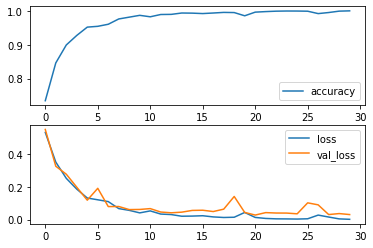

In [78]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.legend(["accuracy"])
plt.subplot(212)
plt.plot(history.history['loss'][:40])
plt.plot(history.history['val_loss'][:40], label = "val_loss")
plt.legend(["loss", "val_loss"])
plt.show()

The loss converges at around 15 epochs.

In [79]:
results = model.evaluate(np.expand_dims(X_test, axis=2), y_test, batch_size=128)

2183/2183 [==============================] - 1s 397us/sample - loss: 0.0264 - acc: 0.9940


The accuracy on the testing set is 99,4%.

In [96]:
unique, counts = np.unique(y_test, return_counts=True)
print(f"The testing set contains {counts[0]} normal recordings and {counts[1]} with myocardial infarction.\nLet's compute the confusion matrix.")

The testing set contains 576 normal recordings and 1607 with myocardial infarction.
Let's compute the confusion matrix.


In [97]:
predictions = model.predict(np.expand_dims(X_test, axis=2))
confusion_matrix = tf.confusion_matrix(y_test, predictions[:,1] > 0.5)
sess = tf.Session()
with sess.as_default():
        print(sess.run(confusion_matrix))

[[ 573    3]
 [  10 1597]]


573/576 MI were correctly classified

1597/1607 normal beats were correctly classified

10 normal beats were classified as MI

3 MI were classified as normal